In [6]:
from tkinter.scrolledtext import example
import faceNetArchitectures
import tensorflow as tf
import cv2
from tensorflow.keras.models import load_model as tf_load
import matplotlib.pyplot as plt
import os 
import sys
sys.path.append("..//utils/")
from slp_utils_XL import crop_from_com
from triangulation_utils import unDistortPoints, camera_matrix, triangulate_confThresh_lowestErr
sys.path.append("..//camera_calibration/")
import pySBA
import mat73
import numpy as np

In [8]:
head_idx=np.asarray([7, 11])

''' load the training images and faceNet model '''
# set up GPUs
gpu = 0
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_visible_devices(gpus[gpu],'GPU')

# Label3D training data
training_dir = r'C:\Users\xl313\OneDrive\Documents\GitHub\bird_pose_tracking\training_files\Label3D'
training_files = []
for f in os.listdir(training_dir):
    if 'coconut' in f:
        training_files.append(f)

# load the model
faceNet = tf.keras.models.load_model('j4-xl-041025.keras')
faceNet.summary()
singleViewMdl = tf.keras.models.load_model('s5-xl-041025.keras')
singleViewMdl.summary()
training_files

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 128, 128, 4  0           []                               
                                )]                                                                
                                                                                                  
 lambda (Lambda)                [(None, 128, 128, 1  0           ['input_3[0][0]']                
                                ),                                                                
                                 (None, 128, 128, 1                                               
                                ),                                                                
                                 (None, 128, 128, 1                                         

['coconut_peanut_nothing_test.mat']

In [3]:
''' Functions '''
def formatData(data3D):
    nFrames = data3D.shape[0]
    nParts = data3D.shape[1]//3
    data3D = np.reshape(data3D, (nFrames, nParts, 3))
    return (data3D, nFrames, nParts)

def get_crop_info(matfile):
    # get the camera params for this file
    camParams = pySBA.convertParams(matfile['camParams'])
    nCams = camParams.shape[0]
    pt3d, nFrames, nParts = formatData(matfile['data_3D'])
    sba = pySBA.PySBA(camParams, np.NaN, np.NaN, np.NaN, np.NaN)
    # get the 3D distance from each camera for cropping scale
    head_COM = np.nanmean(pt3d[:, head_idx], axis=1)
    allCamScales = np.full((nFrames, nCams), np.NaN)
    allCentroids = np.full((nFrames, nCams, 2), np.NaN)
    for f in range(nFrames):
        this_COM = head_COM[f]
        allCentroids[f] = sba.project(np.tile(this_COM, (nCams, 1)), camParams)  # get reprojected centroid locations
        camDist = sba.rotate(np.tile(this_COM, (nCams, 1)), camParams[:, :3])  # rotate to camera coordinates
        camDist = camDist[:, 2] + camParams[:, 5]  # get z-axis distance ie along optical axis
        allCamScales[f] = camParams[:, 6] / camDist  # convert to focal length divided by distance
    return allCamScales, allCentroids

In [4]:
''' get the camera views, head centroids, and camera scales for each Label3D file '''
all_images = [] # list (len (n_cams,)) of arrays (w, h, n_frames)
all_scales = [] # (n_frames, n_cams)
all_centroids = [] # (n_frames, n_cams, 2)
print('\nloading training files...')
for fn in training_files:
    print(fn)
    file_path = f"{training_dir}\{fn}"
    matfile = mat73.loadmat(file_path)
    scales, centroids = get_crop_info(matfile)
    images = []
    for data in matfile['videos']:
        images.append(data[0])
    all_images.append(images)
    all_scales.append(scales)
    all_centroids.append(centroids)
    
# reformat
all_scales = np.concatenate(all_scales, axis=0)
all_centroids = np.concatenate(all_centroids, axis=0)
n_cams = all_scales.shape[1]
all_cams = []
for c in range(n_cams):
    these_images = np.concatenate([i[c] for i in all_images], axis=3)
    all_cams.append(np.squeeze(these_images))
del all_images


loading training files...
coconut_peanut_nothing_test.mat


In [9]:
all_cams = np.array([np.stack(sublist) for sublist in all_cams])
gray = 0.2989 * all_cams[:,:,:,0,:] + 0.5870 * all_cams[:,:,:,1,:] + 0.1140 * all_cams[:,:,:,2,:]
gray = gray.astype(all_cams.dtype)
np.shape(gray)
all_cams = gray
image_to_show = gray[0,:,:,0] # This accesses the first set, first image
# Plotting the image
image_to_show = tf.image.grayscale_to_rgb(image_to_show)
plt.imshow(image_to_show, cmap='gray')  # 'cmap' specifies that we want to use a grayscale colormap
plt.axis('off')  # This hides the axis to only show the image
plt.show()
print(np.shape(gray))

IndexError: too many indices for array: array is 4-dimensional, but 5 were indexed

In [11]:
image_to_show = tf.image.grayscale_to_rgb(image_to_show)

print(np.shape(image_to_show))


AttributeError: 'numpy.ndarray' object has no attribute 'get_shape'

In [18]:
''' cropping params '''
face_w3d=20 # scaling factor, IL: 0.06, XL: 80/20
face_crop_size=(128,128) # pixels
head_idx=np.asarray([7, 11])

In [19]:
''' crop and resize frames '''
n_frames = all_scales.shape[0]
face_images = np.zeros([n_frames, face_crop_size[1], face_crop_size[0], n_cams], dtype='uint8') # shape (total_frames, ds_h, ds_w)
for n_cam in range(n_cams):
    images = np.transpose(all_cams[n_cam], axes=[2, 0, 1]) 
    scales = all_scales[:, n_cam]
    centroids = all_centroids[:, n_cam]
    for f in range(n_frames):
        if np.isfinite(centroids[f].sum()):
            full_image = images[f]
            head_ctr = np.maximum(centroids[f], 0) # rough x-y head coords as in comNet
            head_ctr[0] = np.min([head_ctr[0], full_image.shape[1]])
            head_ctr[1] = np.min([head_ctr[1], full_image.shape[0]])
            half_width = np.nanmax([np.round(face_w3d * scales[f]), 15]) # minimum 31px image for head
            crop_img, _, _ = crop_from_com(full_image, head_ctr, half_width, face_crop_size)
            face_images[f, :, :, n_cam] = crop_img

Frame: 14 Camera: 3
Centroid: [1083.94304438  266.43284086]
Scale: 4.096441948657055
Head Center after adjustment: [1083.94304438  266.43284086]
Crop Image Shape: (128, 128)
uint8


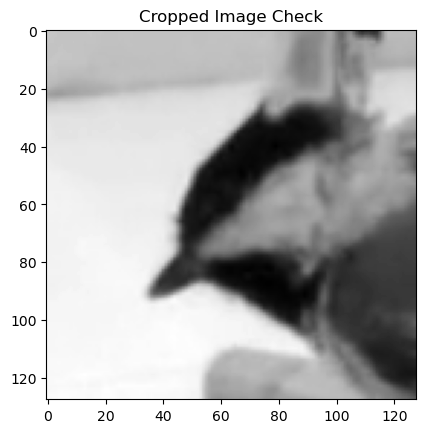

In [20]:
print("Frame:", f, "Camera:", n_cam)
print("Centroid:", centroids[f])
print("Scale:", scales[f])
print("Head Center after adjustment:", head_ctr)
print("Crop Image Shape:", crop_img.shape)
print(crop_img.dtype)
plt.imshow(face_images[0,:,:,0], cmap='gray')
plt.title("Cropped Image Check")
plt.show()

In [3]:
import tensorflow as tf
tf.image.grayscale_to_rgb(face_images[0,:,:,0])

NameError: name 'face_images' is not defined

In [21]:
# only keep frames where head is labeled in all views
label_idx = []
for f in range(n_frames):
    if np.isfinite(np.sum(all_centroids[f])):
        label_idx.append(f)
face_images = face_images[np.asarray(label_idx)]

In [22]:
n_labeled_frames = face_images.shape[0]


In [26]:
faceNet.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 128, 128, 4  0           []                               
                                )]                                                                
                                                                                                  
 lambda (Lambda)                [(None, 128, 128, 1  0           ['input_3[0][0]']                
                                ),                                                                
                                 (None, 128, 128, 1                                               
                                ),                                                                
                                 (None, 128, 128, 1                                         

In [31]:
''' predict seed/no seed - score only '''
# define new network with view-specific weights and make predictions
print('\nreading and predicting...')
jp_layer = [l for l in faceNet.layers if l.name == 'joint_pred'][0]
weights_layer = [l for l in faceNet.layers if l.name == 'view_weights'][0]
pred_model = tf.keras.Model(inputs=faceNet.input, outputs=[jp_layer.output, weights_layer.output])
val = pred_model.predict(face_images, batch_size=200)


reading and predicting...


[array([[2.6781285e-05],
        [3.8090900e-05],
        [5.3568590e-03],
        [7.0969712e-05],
        [3.4840882e-03],
        [9.9999964e-01],
        [9.9929106e-01],
        [9.9999309e-01],
        [9.0110487e-01],
        [3.2360179e-04],
        [9.9878567e-01],
        [9.9695385e-01],
        [9.8918623e-01],
        [9.0406555e-01],
        [9.9994361e-01]], dtype=float32),
 array([[-4.544242  , -1.6626806 , -3.8931558 , -0.42770225],
        [-4.094051  , -1.6567798 , -3.8655457 , -0.5591207 ],
        [-0.4801224 ,  0.06834061, -3.1930828 , -1.6191417 ],
        [-2.741283  , -3.3678308 , -3.0730639 , -0.3710093 ],
        [-0.3033714 , -1.4271228 , -0.70985574, -3.215709  ],
        [-1.2013959 ,  6.20221   ,  5.548772  ,  4.3754334 ],
        [ 2.0698557 , -1.6295812 , -0.34045914,  7.1512146 ],
        [ 4.981197  , -1.3487115 , -0.05561624,  8.298429  ],
        [ 1.2387719 ,  0.03156061,  0.04561295,  0.89361614],
        [-0.65181106, -3.2769904 , -0.8513944 , -3

In [38]:
val[0][1]

array([3.80909e-05], dtype=float32)

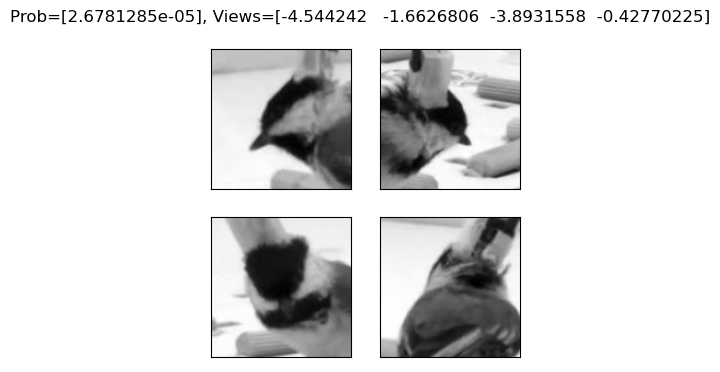

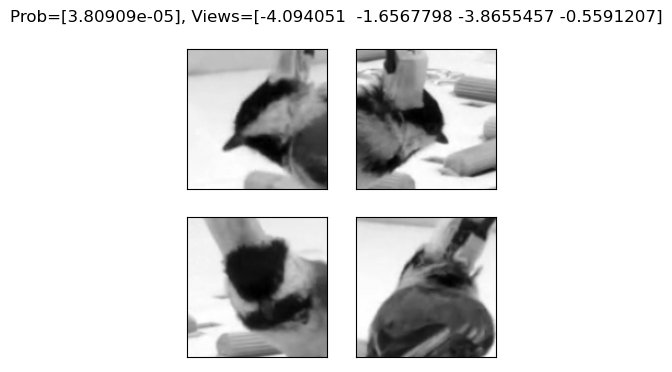

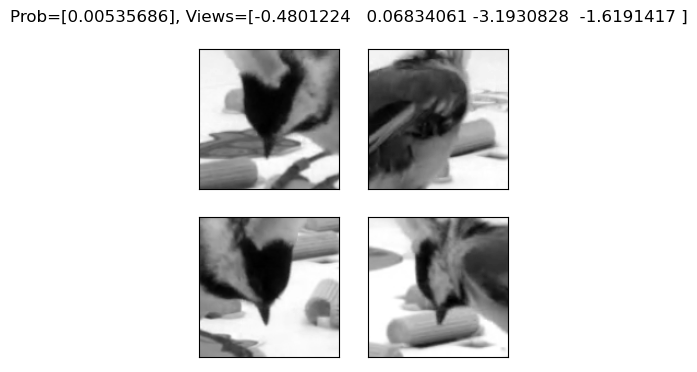

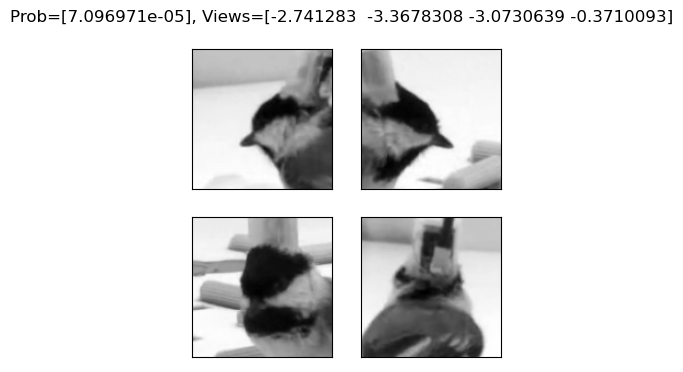

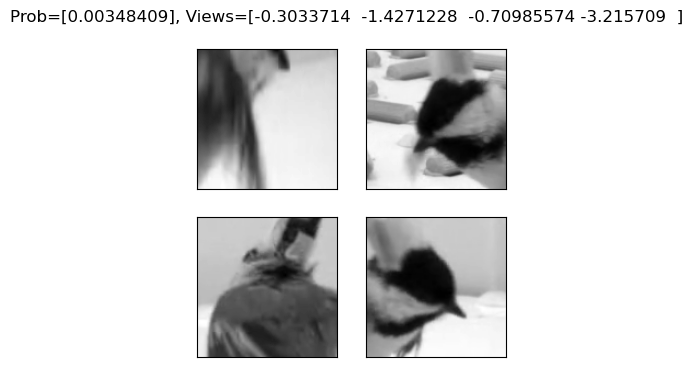

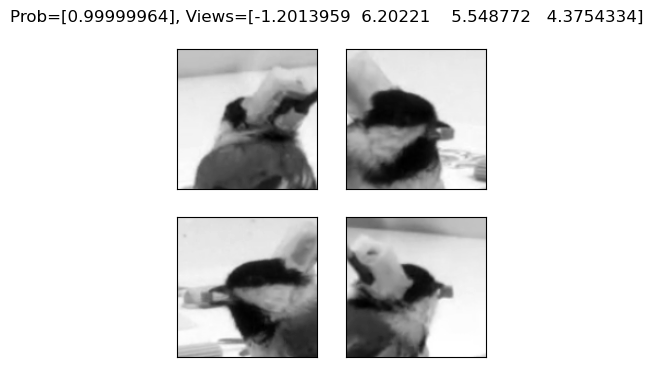

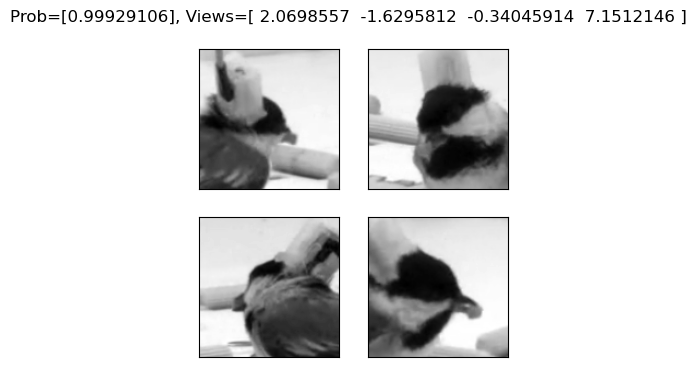

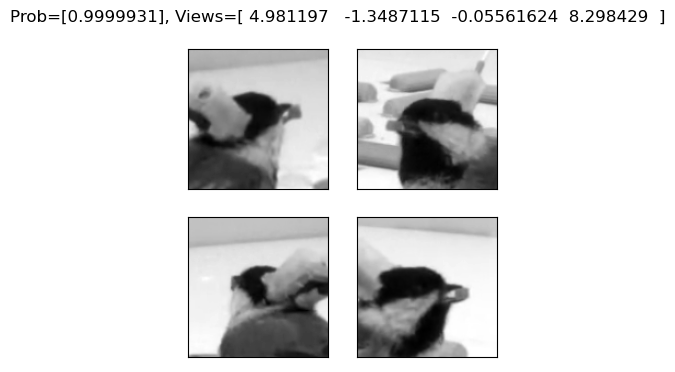

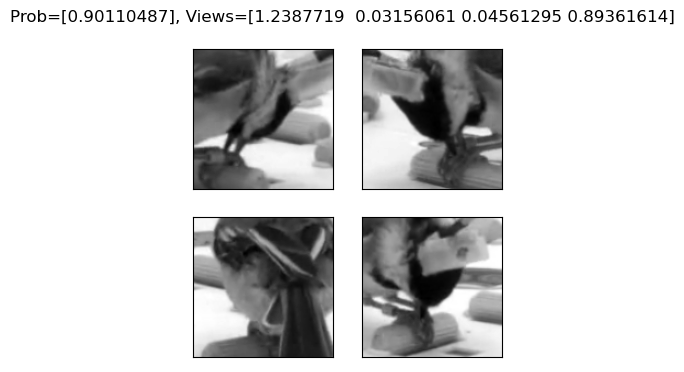

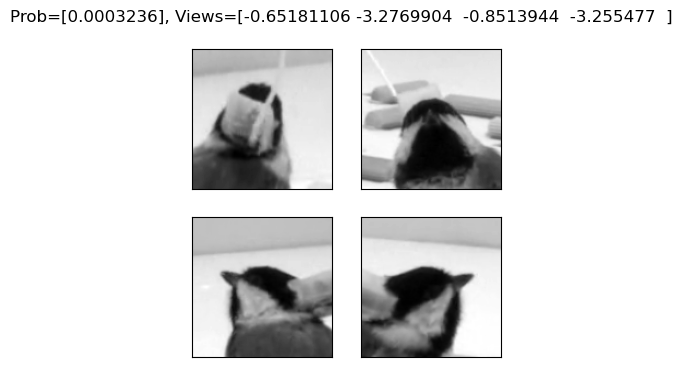

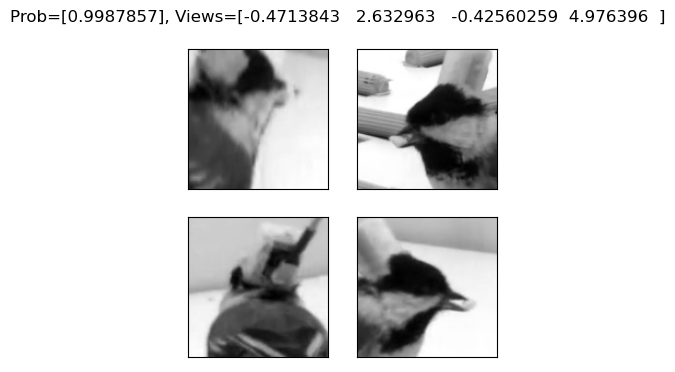

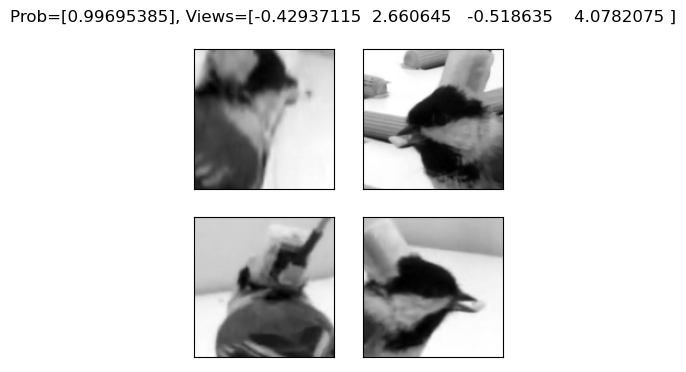

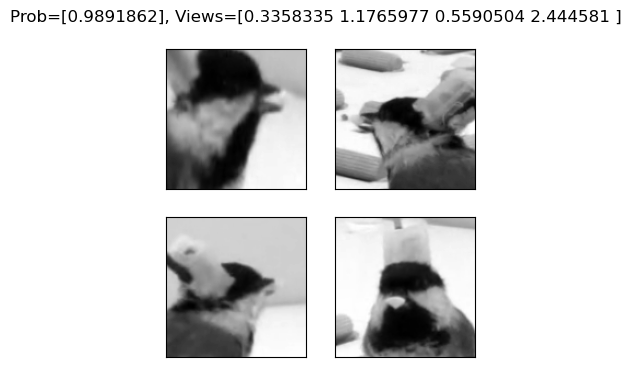

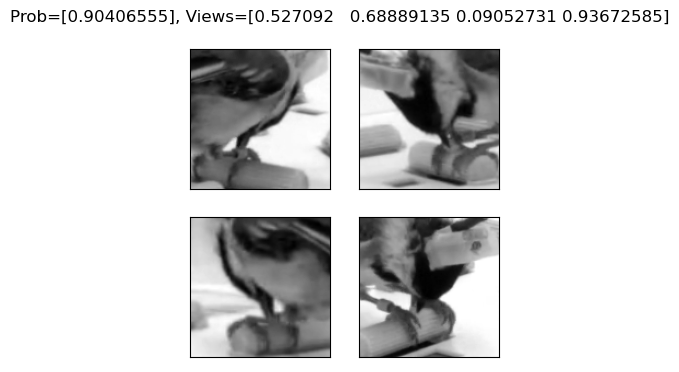

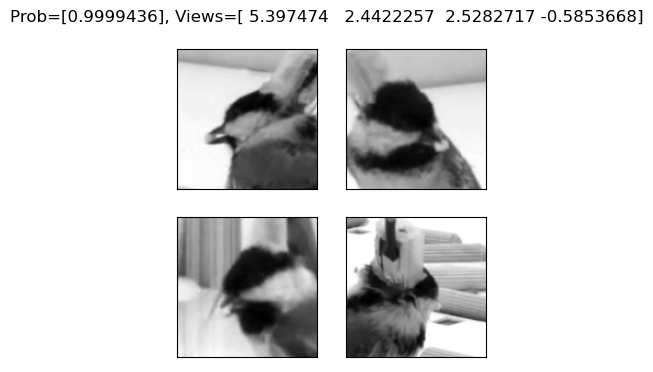

In [44]:
''' plot 10 random frames to check output '''
# example_idx = np.random.randint(n_labeled_frames, size=10)
for ex in range(15):
    # get the weight and score

    # plot the face and label with score
    f, ax = plt.subplots(2, 2, figsize=(4, 4))
    ax[0, 0].imshow(face_images[ex, :, :, 0], cmap='gray')
    ax[0, 1].imshow(face_images[ex, :, :, 1], cmap='gray')
    ax[1, 0].imshow(face_images[ex, :, :, 2], cmap='gray')
    ax[1, 1].imshow(face_images[ex, :, :, 3], cmap='gray')
    for i in range(2):
        for j in range(2):
            ax[i, j].set_xticks([])
            ax[i, j].set_yticks([])

    # label with the score
    f.suptitle(f'Prob={val[0][ex]}, Views={val[1][ex,:]}')
    plt.show()